<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

### <font color='red'>Additional reference</font>

1. https://www.cs.rpi.edu/~zaki/PaperDir/LINK06.pdf
1. https://www.sciencedirect.com/science/article/pii/S2666285X21000406
1. http://ijetms.in/Vol-4-issue-5/IJETMS-SE-016.pdf

In [1]:
# Importing Libraries
# pip install tables

import time
time_start = time.time()

import warnings
warnings.filterwarnings("ignore")

import os
import csv
import random
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable 

from collections import Counter
from scipy.stats import randint as sp_randint

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from scipy.sparse.linalg import svds, eigs

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import networkx as nx

import xgboost as xgb

tqdm.pandas()

## <font color = 'red'>NOTE :</font>

Before executing the bellow cells we need to ensure that the supporing files are present in the project directory.
1. `train.csv`
2. `missing_edges_final.p`.

`missing_edges_final.p` is a file from **pretrained** dataset and can be obtained from `data/after_eda/missing_edges_final.p` directory.

In [2]:
%%bash

cd /home/jishnu/AAIC/17_Facebook
mkdir data
mv train.csv '/home/jishnu/AAIC/17_Facebook/data/' 
# gdown --id 1--L6-VqVMbYr21Bi54t6W1_BgGUBvpJN #train.csv
cd /home/jishnu/AAIC/17_Facebook/data/
mkdir after_eda
mkdir fea_sample
cd /home/jishnu/AAIC/17_Facebook
mv missing_edges_final.p '/home/jishnu/AAIC/17_Facebook/data/after_eda/' 

In [3]:
# Reading graph

if not os.path.isfile('data/after_eda/train_woheader.csv'):
    
    traincsv = pd.read_csv('data/train.csv')
    print(f'Null Values : {traincsv[traincsv.isna().any(1)]}\n')
    print(f'\nPrint Dataset info.\t\t: {traincsv.info()}\n')
    
    print(f'\nNumber of diplicate entries\t: {sum(traincsv.duplicated())}\n')
    
    traincsv.to_csv('data/after_eda/train_woheader.csv', header = False, index = False)
    
    print('\nSAVED THE GRAPH INTO FILE\n')
    
g = nx.read_edgelist('data/after_eda/train_woheader.csv', delimiter = ',',
                                                         create_using = nx.DiGraph(),nodetype = int)
print(f'\nGraph Information\t\t:  {nx.info(g)}')   

Null Values : Empty DataFrame
Columns: [source_node, destination_node]
Index: []

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
 #   Column            Dtype
---  ------            -----
 0   source_node       int64
 1   destination_node  int64
dtypes: int64(2)
memory usage: 144.0 MB

Print Dataset info.		: None


Number of diplicate entries	: 0


SAVED THE GRAPH INTO FILE


Graph Information		:  DiGraph with 1862220 nodes and 9437519 edges


DiGraph with 76 nodes and 60 edges


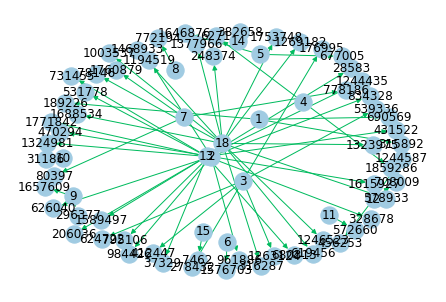

In [4]:
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

# if not os.path.isfile('train_woheader_sample.csv'): Original

if not os.path.isfile('train_woheader_sample.csv'):
    
    pd.read_csv('data/train.csv', nrows = 60).to_csv('train_woheader_sample.csv',
                                                             header = False, index = False)
    
subgraph = nx.read_edgelist('train_woheader_sample.csv', delimiter = ',',
                                                        create_using = nx.DiGraph(), nodetype = int)

pos = nx.spring_layout(subgraph)

nx.draw(subgraph, pos, node_color = '#A0CBE2', edge_color = '#00bb5e', width = 1,
                                                    edge_cmap = plt.cm.Blues, with_labels = True)
plt.savefig("graph_sample.pdf")

print(nx.info(subgraph))

## 1. Exploratory Data Analysis

In [5]:
# No of Unique persons 

print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


### 1.1 No of followers for each person

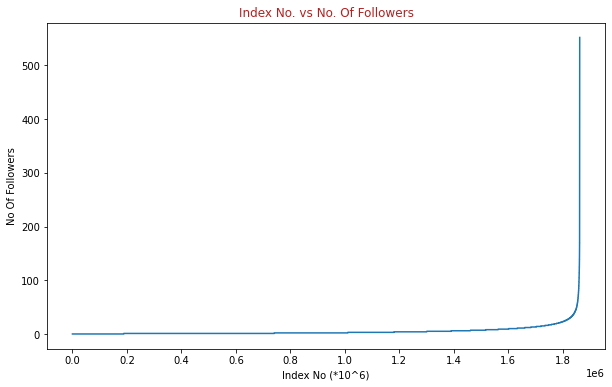

In [6]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()

plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xticks(range(0, 2000000, 200000))

plt.title('Index No. vs No. Of Followers', c = 'firebrick')
plt.xlabel('Index No (*10^6)')
plt.ylabel('No Of Followers')

plt.show()

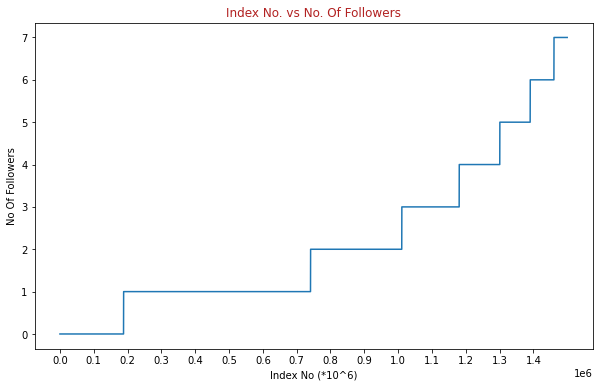

In [7]:
# Precisely checking on a specific range

indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()

plt.figure(figsize = (10,6))
plt.plot(indegree_dist[0:1500000])
plt.xticks(range(0, 1500000, 100000))

plt.title('Index No. vs No. Of Followers', c = 'firebrick')

plt.xlabel('Index No')
plt.xlabel('Index No (*10^6)')
plt.ylabel('No Of Followers')

plt.show()

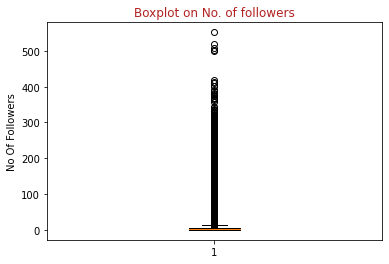

In [8]:
# Boxplot on No. of followers

plt.boxplot(indegree_dist)

plt.title('Boxplot on No. of followers', c = 'firebrick')
plt.ylabel('No Of Followers')

plt.show()

In [9]:
### 90-100 percentile

for i in range(11):
    
    print(f'{90 + i} percentile value is {np.percentile(indegree_dist, 90 + i)}')

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


In [10]:
### 99-100 percentile

for i in range(10, 110, 10):
    
    print(f'{99 + (i/100)} percentile value is {np.percentile(indegree_dist, 99 + (i/100))}')

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


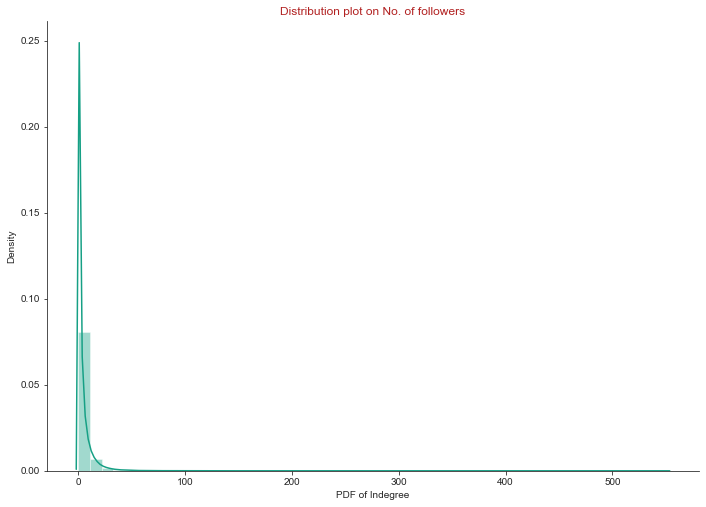

In [11]:
# Distribution plot on No. of followers

sns.set_style('ticks')
fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')

plt.title('Distribution plot on No. of followers', c = 'firebrick')
plt.xlabel('PDF of Indegree')

sns.despine()

### 1.2 No of people each person is following

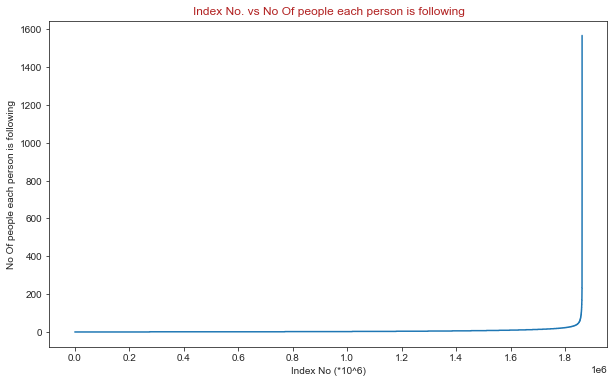

In [12]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()

plt.figure(figsize = (10,6))
plt.plot(outdegree_dist)
plt.xticks(range(0, 2000000, 200000))

plt.title('Index No. vs No Of people each person is following', c = 'firebrick')
plt.xlabel('Index No')
plt.xlabel('Index No (*10^6)')
plt.ylabel('No Of people each person is following')

plt.show()

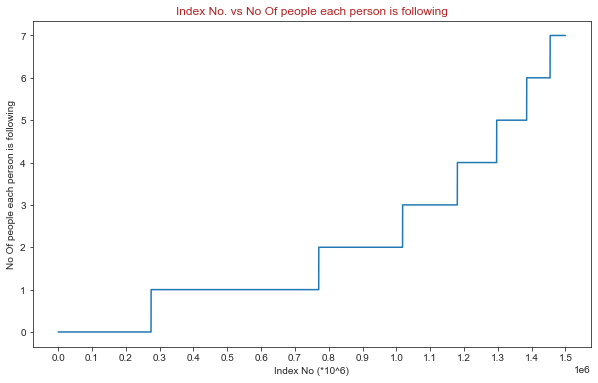

In [13]:
# Precisely checking on a specific range

indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()

plt.figure(figsize = (10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xticks(range(0, 1600000, 100000))

plt.title('Index No. vs No Of people each person is following', c = 'firebrick')
plt.xlabel('Index No')
plt.xlabel('Index No (*10^6)')
plt.ylabel('No Of people each person is following')

plt.show()

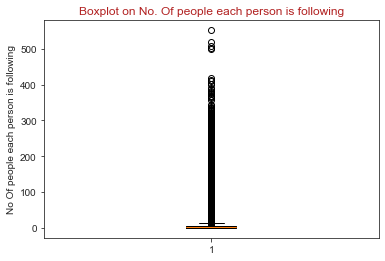

In [14]:
# Boxplot on No Of people each person is following

plt.boxplot(indegree_dist)

plt.title('Boxplot on No. Of people each person is following', c = 'firebrick')
plt.ylabel('No Of people each person is following')

plt.show()

In [15]:
### 90-100 percentile

for i in range(11):
    
    print(f'{90 + i} percentile value is {np.percentile(outdegree_dist, 90 + i)}')

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [16]:
### 99-100 percentile

for i in range(10, 110, 10):
    
    print(f'{90 + (i/100)} percentile value is {np.percentile(outdegree_dist, 99 + (i/100))}')

90.1 percentile value is 42.0
90.2 percentile value is 45.0
90.3 percentile value is 48.0
90.4 percentile value is 52.0
90.5 percentile value is 56.0
90.6 percentile value is 63.0
90.7 percentile value is 73.0
90.8 percentile value is 90.0
90.9 percentile value is 123.0
91.0 percentile value is 1566.0


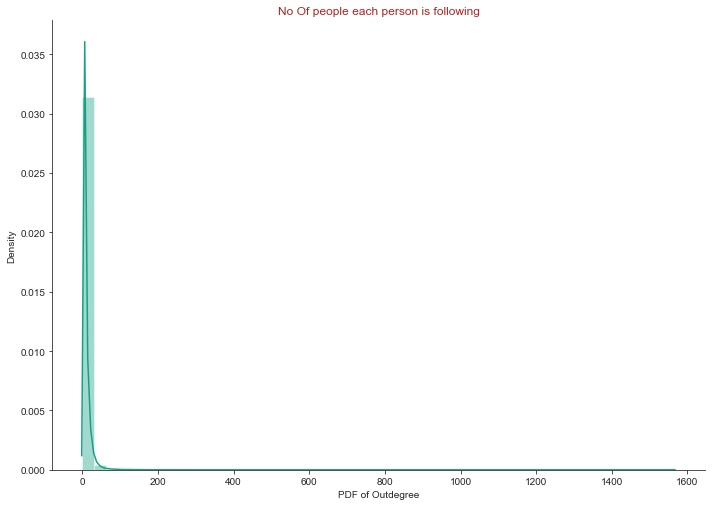

In [17]:
# Distribution plot on No Of people each person is following

sns.set_style('ticks')

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
plt.title('No Of people each person is following', c = 'firebrick')

sns.despine()

In [18]:
print('No of persons those are not following anyone are' , sum(np.array(outdegree_dist) == 0),'and % is',
                                sum(np.array(outdegree_dist) == 0) * 100 / len(outdegree_dist))

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [19]:
print('No of persons having zero followers are' ,  sum(np.array(indegree_dist) == 0), 'and % is',
                                sum(np.array(indegree_dist) == 0) * 100 / len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [20]:
count=0

for i in g.nodes():
    
    if len(list(g.predecessors(i))) == 0:
        if len(list(g.successors(i))) == 0:
            count += 1
            
print('No of persons those are not not following anyone and also not having any followers are', count)

No of persons those are not not following anyone and also not having any followers are 0


### 1.3 both followers + following 

In [21]:
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())

d = Counter(dict_in) + Counter(dict_out)

in_out_degree = np.array(list(d.values()))

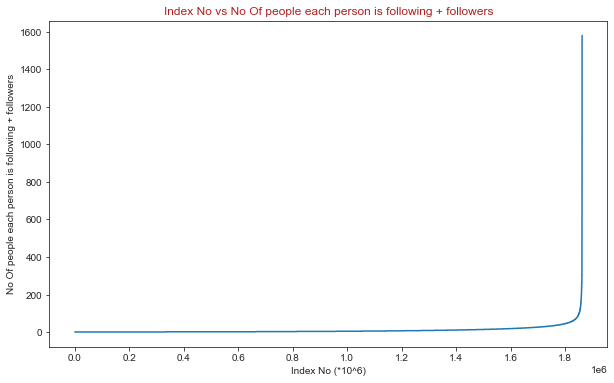

In [22]:
# Index No vs No Of people each person is following + followers

in_out_degree_sort = sorted(in_out_degree)

plt.figure(figsize = (10,6))
plt.plot(in_out_degree_sort)
plt.xticks(range(0, 2000000, 200000))

plt.title('Index No vs No Of people each person is following + followers',  c = 'firebrick')
plt.xlabel('Index No')
plt.xlabel('Index No (*10^6)')
plt.ylabel('No Of people each person is following + followers')

plt.show()

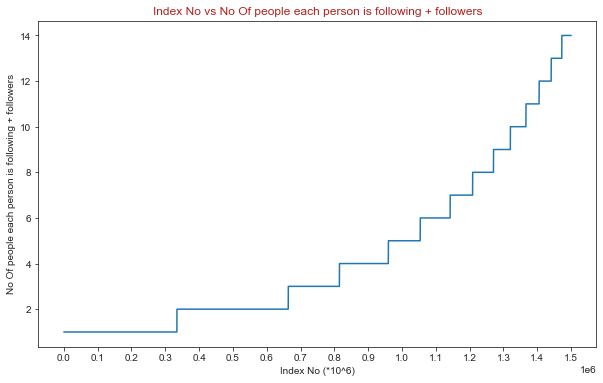

In [23]:
# Precisely checking on a specific range

in_out_degree_sort = sorted(in_out_degree)

plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xticks(range(0, 1600000, 100000))

plt.title('Index No vs No Of people each person is following + followers',  c = 'firebrick')
plt.xlabel('Index No (*10^6)')
plt.ylabel('No Of people each person is following + followers')

plt.show()

In [24]:
### 90-100 percentile

for i in range(11):

    print(f'{90 + i} percentile value is {np.percentile(in_out_degree_sort, 90 + i)}') 

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [25]:
### 99-100 percentile

for i in range(10,110,10):
    
    print(f'{99 + (i/100)} percentile value is {np.percentile(in_out_degree_sort, 99 + (i/100))}')

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [26]:
print(f'Min of no of followers + following is {in_out_degree.min()}\n')

print(f'{np.sum(in_out_degree == in_out_degree.min())} persons having minimum no of followers + following')

Min of no of followers + following is 1

334291 persons having minimum no of followers + following


In [27]:
print(f'Max of no of followers + following is {in_out_degree.max()}\n')

print(f'{np.sum(in_out_degree==in_out_degree.max())} persons having maximum no of followers + following')

Max of no of followers + following is 1579

1 persons having maximum no of followers + following


In [28]:
print('No of persons having followers + following less than 10 are', np.sum(in_out_degree < 10))

No of persons having followers + following less than 10 are 1320326


In [29]:
print(f'No of weakly connected components {len(list(nx.weakly_connected_components(g)))}\n')

count = 0

for i in list(nx.weakly_connected_components(g)):
    
    if len(i) == 2:
        count += 1
        
print(f'weakly connected components wit 2 nodes {count}')

No of weakly connected components 45558

weakly connected components wit 2 nodes 32195


## 2. Posing a problem as classification problem 

### 2.1 Generating some edges which are not present in graph for supervised learning  

Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [30]:
# Generating bad edges from given graph

if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    
    #getting all set of edges
    r = csv.reader(open('data/after_eda/train_woheader.csv', 'r'))
    
    edges = dict()
    
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
    missing_edges = set([])
    
    while (len(missing_edges)<9437519):
        
        a = random.randint(1, 1862220)
        b = random.randint(1, 1862220)
        tmp = edges.get((a,b), -1)
        
        if tmp == -1 and a != b:
            
            try:
                if nx.shortest_path_length(g, source = a, target = b) > 2: 
                    missing_edges.add((a,b))
                    
                else:
                    continue  
                    
            except:  
                    missing_edges.add((a, b)) 
                    
        else:
            continue
            
    pickle.dump(missing_edges, open('data/after_eda/missing_edges_final.p', 'wb'))
    
else:
    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.p', 'rb'))
    
print(f'Length of missing edges : {len(missing_edges)}')    

Length of missing edges : 9437519


## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [31]:
if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv'))\
                    and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
        
    #reading total data df
    df_pos = pd.read_csv('data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print(f'Number of nodes in the graph with edges : {df_pos.shape[0]}')
    print(f'Number of nodes in the graph without edges : {df_neg.shape[0]}\n')
    
    '''
    Trian test split 
    Spiltted data into 80-20 
    positive links and negative links seperatly because we need positive
            training data only for creating graph and for feature generation
    '''
    
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)), 
                                                                 test_size = 0.2, random_state = 9)
    
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)), 
                                                                 test_size = 0.2, random_state = 9)

    print('='*60)
    print(f'\nNumber of nodes in the train data graph with edges :\n\
                                                    {X_train_pos.shape[0]} = {y_train_pos.shape[0]}')
          
    print(f'Number of nodes in the train data graph without edges : \n\
                                                    {X_train_neg.shape[0]} = {y_train_neg.shape[0]}\n')
    
    print('='*60)
    print(f'\nNumber of nodes in the test data graph with edges : \n\
                                                    {X_test_pos.shape[0]} = {y_test_pos.shape[0]}')
    
    print(f'Number of nodes in the test data graph without edges : \n\
                                                    {X_test_neg.shape[0]} = {y_test_neg.shape[0]}')

    #removing header and saving
    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv', header = False, index = False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv', header = False, index = False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv', header = False, index = False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv', header = False, index = False)
    
    del missing_edges
    
else:
    #Graph from Traing data only 
    del missing_edges

Number of nodes in the graph with edges : 9437519
Number of nodes in the graph without edges : 9437519


Number of nodes in the train data graph with edges :
                                                    7550015 = 7550015
Number of nodes in the train data graph without edges : 
                                                    7550015 = 7550015


Number of nodes in the test data graph with edges : 
                                                    1887504 = 1887504
Number of nodes in the test data graph without edges : 
                                                    1887504 = 1887504


In [32]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
                                    (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):  
    
    train_graph = nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter = ',', 
                                   create_using = nx.DiGraph(), nodetype = int)
    test_graph = nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter = ',', 
                                  create_using = nx.DiGraph(), nodetype = int)
    print(nx.info(train_graph))
    print('\n')
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print(f'\nno of people common in train and test --  {trY_teY}')
    print(f'\nno of people present in train but not present in test -- {trY_teN}')

    print(f'\nno of people present in test but not present in train -- {teY_trN}')
    
    p_value = round(teY_trN/len(test_nodes_pos) * 100, 3)
    print(f'\n% of people not there in Train but exist in Test in total Test data are {p_value} %')

DiGraph with 1780722 nodes and 7550015 edges


DiGraph with 1144623 nodes and 1887504 edges

no of people common in train and test --  1063125

no of people present in train but not present in test -- 717597

no of people present in test but not present in train -- 81498

% of people not there in Train but exist in Test in total Test data are 7.12 %


In [33]:
# Final train and test data sets

if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
    (not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
    (not os.path.isfile('data/train_y.csv')) and \
    (not os.path.isfile('data/test_y.csv')) and \
    (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
    (os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
    (os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
    (os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv',
                                                          names = ['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv',
                                                         names =['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv',
                                                          names =['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv',
                                                         names =['source_node', 'destination_node'])

    print(f'\nNumber of nodes in the train data graph with edges    : {X_train_pos.shape[0]}')
    print(f'Number of nodes in the train data graph without edges : {X_train_neg.shape[0]}\n')
    print('='*60)
    print(f'\nNumber of nodes in the test data graph with edges    : {X_test_pos.shape[0]}')
    print(f'Number of nodes in the test data graph without edges : {X_test_neg.shape[0]}')

    X_train = X_train_pos.append(X_train_neg,ignore_index = True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    
    X_test = X_test_pos.append(X_test_neg,ignore_index = True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header = False, index = False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header = False, index = False)
    
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header = False, index = False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header = False, index = False)


Number of nodes in the train data graph with edges    : 7550015
Number of nodes in the train data graph without edges : 7550015


Number of nodes in the test data graph with edges    : 1887504
Number of nodes in the test data graph without edges : 1887504


In [34]:
print(f'Data points in train data\t  : {X_train.shape}')
print(f'\nData points in test data\t  : {X_test.shape}')
print(f'\nShape of traget variable in train : {y_train.shape}')
print(f'\nShape of traget variable in test  : {y_test.shape}')

time_eda_end = time.time()

print(f'\nTotal time took for EDA analysis  : {round((time_eda_end - time_start) / 60, 1)} minutes')

Data points in train data	  : (15100030, 2)

Data points in test data	  : (3775008, 2)

Shape of traget variable in train : (15100030,)

Shape of traget variable in test  : (3775008,)

Total time took for EDA analysis  : 4.4 minutes


## Feature Engineering On Graphs

In [1]:
# Importing Libraries
# pip install tables

import time
time_start = time.time()

import warnings
warnings.filterwarnings("ignore")

import os
import csv
import random
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable 

from collections import Counter
from scipy.stats import randint as sp_randint

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from scipy.sparse.linalg import svds, eigs

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import networkx as nx

import xgboost as xgb

tqdm.pandas()

### 1. Reading Data

In [2]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    
    train_graph = nx.read_edgelist('data/after_eda/train_pos_after_eda.csv', delimiter = ',',
                                                       create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    
else:
    print('File is missing. Run previous cells OR download it from G-Drive')

DiGraph with 1780722 nodes and 7550015 edges


### 2. Similarity measures

#### 2.1 Jaccard Distance:
http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [3]:
# For followees

def jaccard_for_followees(a, b):
    
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        
        return 0
    
    return sim

In [4]:
# For followers

def jaccard_for_followers(a,b):
    
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                             (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    
    except:
        
        return 0

#### 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [5]:
# For followees

def cosine_for_followees(a, b):
    
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    
    except:
        
        return 0

In [6]:
def cosine_for_followers(a,b):
    
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                 (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    
    except:
        
        return 0

#### 3. Ranking Measures
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

<img src='https://i.imgur.com/JMu2MuP.jpg'>

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale.) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. <b>(The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.</b>

#### 3.1 Page Ranking

https://en.wikipedia.org/wiki/PageRank


In [7]:
if not os.path.isfile('data/fea_sample/page_rank.p'):
    
    pr = nx.pagerank(train_graph, alpha = 0.85)
    pickle.dump(pr, open('data/fea_sample/page_rank.p', 'wb'))
    
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p', 'rb'))

In [8]:
mean_page = float(sum(pr.values())) / len(pr)

print(f'Min. Page Rank : {round(pr[min(pr, key=pr.get)], 8)}')
print(f'\nMax. Page Rank : {round(pr[max(pr, key=pr.get)], 8)}')
print(f'\nMean Page Rank : {round(mean_page, 8)}')

Min. Page Rank : 1.7e-07

Max. Page Rank : 2.71e-05

Mean Page Rank : 5.6e-07


### 4. Other Graph Features

#### 4.1 Shortest path:
Getting Shortest path between twoo nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path. 

In [9]:
#if has direct edge then deleting that edge and calculating shortest path

def compute_shortest_path_length(a,b):
    
    p=-1
    
    try:
        
        if train_graph.has_edge(a,b):
            
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
            
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            
        return p
    
    except:
        
        return -1

#### 4.2 Checking for same community

In [10]:
# Getting weekly connected edges from graph 

wcc = list(nx.weakly_connected_components(train_graph))

def belongs_to_same_wcc(a, b):
    
    index = []
    
    if train_graph.has_edge(b, a):
        return 1
    
    if train_graph.has_edge(a, b):
        
            for i in wcc:
                
                if a in i:
                    index = i
                    break
                    
            if (b in index):
                train_graph.remove_edge(a, b)
                
                if compute_shortest_path_length(a, b) == -1:
                    train_graph.add_edge(a, b)
                    return 0
                
                else:
                    train_graph.add_edge(a, b)
                    return 1
                
            else:
                return 0
            
    else:
            for i in wcc:
                
                if a in i:
                    index = i
                    break
                    
            if(b in index):
                return 1
            
            else:
                
                return 0

#### 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [11]:
# Adar index

def calc_adar_in(a, b):
    
    sum = 0
    
    try:
        n = list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        
        if len(n)!= 0:
            for i in n:
                sum = sum + (1/np.log10(len(list(train_graph.predecessors(i)))))
                
            return sum
        
        else:
            return 0
        
    except:
        return 0

#### 4.4 Is persion was following back:

In [12]:
def follows_back(a, b):
    
    if train_graph.has_edge(b, a):
        
        return 1
    else:
        
        return 0

#### 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [13]:
if not os.path.isfile('data/fea_sample/katz.p'):
    
    katz = nx.katz.katz_centrality(train_graph, alpha = 0.005, beta = 1)
    pickle.dump(katz, open('data/fea_sample/katz.p', 'wb'))
    
else:
    katz = pickle.load(open('data/fea_sample/katz.p', 'rb'))

In [14]:
mean_katz = float(sum(katz.values())) / len(katz)

print(f'Min. katz score : {round(katz[min(katz, key=katz.get)], 8)}')
print(f'\nMax. katz score : {round(katz[max(katz, key=katz.get)], 8)}')
print(f'\nMean katz score : {round(mean_katz, 8)}')

Min. katz score : 0.00073135

Max. katz score : 0.00339455

Mean katz score : 0.00074838


#### 4.6 Hits Score
The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [15]:
if not os.path.isfile('data/fea_sample/hits.p'):
    
    hits = nx.hits(train_graph, max_iter = 100, tol = 1e-08, nstart = None, normalized = True)
    pickle.dump(hits, open('data/fea_sample/hits.p', 'wb'))
    
else:
    hits = pickle.load(open('data/fea_sample/hits.p', 'rb'))

In [16]:
mean_hits = float(sum(hits[0].values())) / len(hits[0])

print(f'Min. hits score : {round(hits[0][min(hits[0], key=hits[0].get)], 8)}')
print(f'\nMax. hits score : {round(hits[0][max(hits[0], key=hits[0].get)], 8)})')
print(f'\nMean hits score : {round(mean_hits, 8)}')

Min. hits score : -0.0

Max. hits score : 0.00486865)

Mean hits score : 5.6e-07


### 5. Featurization

#### 5. 1 Reading a sample of Data from both train and test

In [17]:
%%bash

cp data/after_eda/train_after_eda.csv train_after_eda.csv
cp data/after_eda/test_after_eda.csv test_after_eda.csv

cp data/train_y.csv train_y.csv
cp data/test_y.csv test_y.csv

In [18]:
# https://stackoverflow.com/a/22259008/4084039

if os.path.isfile('train_after_eda.csv'):
    
    filename = "train_after_eda.csv"
    
    '''
    you uncomment this line, if you dont know the lentgh of the file name
    here we have hardcoded the number of lines as 15100030
    '''
    
#     n_train = sum(1 for line in open(filename)) # Number of records in file (excludes header)
    
    n_train =  15100028
    s = 100000 #desired sample size
    
    skip_train = sorted(random.sample(range(1, n_train + 1), n_train - s))

In [19]:
# https://stackoverflow.com/a/22259008/4084039

if os.path.isfile('train_after_eda.csv'):
    
    filename = "test_after_eda.csv"
    
    '''
    you uncomment this line, if you dont know the lentgh of the file name
    here we have hardcoded the number of lines as 3775008
    '''
    
#     n_test = sum(1 for line in open(filename)) # Number of records in file (excludes header)
    
    n_test = 3775006
    s = 50000 #desired sample size
    
    skip_test = sorted(random.sample(range(1, n_test + 1), n_test - s))

In [20]:
print(f'Number of rows in the train data file\t\t\t\t: {n_train}')
print(f'\nNumber of rows we are going to elimiate in train data are\t: {len(skip_train)}')
print(f'\nNumber of rows in the test data file\t\t\t\t: {n_test}')
print(f'\nNumber of rows we are going to elimiate in test data are\t: {len(skip_test)}')

Number of rows in the train data file				: 15100028

Number of rows we are going to elimiate in train data are	: 15000028

Number of rows in the test data file				: 3775006

Number of rows we are going to elimiate in test data are	: 3725006


In [21]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows = skip_train,
                                                            names = ['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows = skip_train,
                                                            names = ['indicator_link'])
print(f'Our train matrix size : {df_final_train.shape}')
df_final_train.head(3)

Our train matrix size : (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,791618,1356611,1
2,65493,26839,1


In [22]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows = skip_train,
                                                            names = ['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_train,
                                                            names = ['indicator_link'])
print(f'Our train matrix size : {df_final_test.shape}')

df_final_test.head(3)

Our train matrix size : (25233, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1579546,990222,1
2,539116,1687019,1


## 5.2 Adding a set of features

__Creating these each features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [23]:
def compute_features_stage1(df_final):
    
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    
    for i,row in df_final.iterrows():
        
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
            
        except:
            s1 = set()
            s2 = set()
            
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
            
        except:
            d1 = set()
            d2 = set()
            
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return  num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees

In [24]:
#mapping jaccrd followees to train and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                    jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)

df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                    jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)


#mapping jaccrd followers to train and test data
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                    jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                    jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    
    
#mapping cosine_followees to train and test data
df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                    cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                    cosine_for_followees(row['source_node'],row['destination_node']),axis=1)


#mapping cosine_followers to train and test data
df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                    cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                    cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

In [25]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees'] \
                                                                = compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees'] \
                                                                = compute_features_stage1(df_final_test)
    
    hdf = pd.HDFStore('data/fea_sample/storage_sample_stage1.h5')
    
    hdf.put('train_df', df_final_train, format ='table', data_columns = True)
    hdf.put('test_df', df_final_test, format ='table', data_columns = True)
    hdf.close()
    
else:
    df_final_train = pd.read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df', mode = 'r')
    df_final_test = pd.read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df', mode = 'r')

In [26]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followees,jaccard_followers,cosine_followees,cosine_followers,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees
0,273084,1505602,1,0.0,0,0,0,11,15,6,8,0,0
1,791618,1356611,1,0.0,0,0,0,2,1,3,2,0,0
2,65493,26839,1,0.0,0,0,0,14,19,8,0,1,0


#### 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [27]:
if not os.path.isfile('data/fea_sample/storage_sample_stage2.h5'):
    
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: 
                                    calc_adar_in(row['source_node'], row['destination_node']), axis = 1)
    
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row:
                                    calc_adar_in(row['source_node'], row['destination_node']), axis = 1)

    #---------------------------------------------------------------------------------------------------
    
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row:
                                    follows_back(row['source_node'], row['destination_node']), axis = 1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row:
                                    follows_back(row['source_node'], row['destination_node']), axis = 1)

    #---------------------------------------------------------------------------------------------------
    
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row:
                            belongs_to_same_wcc(row['source_node'], row['destination_node']), axis = 1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row:
                            belongs_to_same_wcc(row['source_node'], row['destination_node']), axis = 1)
    
    #---------------------------------------------------------------------------------------------------
    
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row:
                    compute_shortest_path_length(row['source_node'], row['destination_node']), axis = 1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row:
                    compute_shortest_path_length(row['source_node'], row['destination_node']), axis = 1)

    
    hdf = pd.HDFStore('data/fea_sample/storage_sample_stage2.h5')
    
    hdf.put('train_df', df_final_train, format = 'table', data_columns = True)
    hdf.put('test_df', df_final_test, format = 'table', data_columns = True)
    
    hdf.close()
    
else:
    
    df_final_train = pd.read_hdf('data/fea_sample/storage_sample_stage2.h5', 'train_df', mode = 'r')
    df_final_test = pd.read_hdf('data/fea_sample/storage_sample_stage2.h5', 'test_df', mode = 'r')

In [28]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followees,jaccard_followers,cosine_followees,cosine_followers,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path
0,273084,1505602,1,0.0,0,0,0,11,15,6,8,0,0,0.0,0,1,4
1,791618,1356611,1,0.0,0,0,0,2,1,3,2,0,0,0.0,0,0,-1
2,65493,26839,1,0.0,0,0,0,14,19,8,0,1,0,0.0,0,1,2


#### 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features
In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [29]:
# Weight for source and destination of each link

Weight_in = {}
Weight_out = {}

for i in  tqdm(train_graph.nodes()):
    
    s1 = set(train_graph.predecessors(i))
    w_in = 1.0 / (np.sqrt(1 + len(s1)))
    Weight_in[i] = w_in
    
    s2 = set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1 + len(s2)))
    Weight_out[i] = w_out
    
# For imputing with mean

mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|█████████████████████████████| 1780722/1780722 [00:11<00:00, 153399.16it/s]


In [30]:
df_final_train.shape

(100002, 17)

In [31]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x :
                                                                    Weight_in.get(x, mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x :
                                                                    Weight_out.get(x, mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x :
                                                                    Weight_in.get(x, mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x :
                                                                    Weight_out.get(x, mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2 * df_final_train.weight_in + 1 * df_final_train.weight_out)
    df_final_train['weight_f4'] = (1 * df_final_train.weight_in + 2 * df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2 * df_final_test.weight_in + 1 * df_final_test.weight_out)
    df_final_test['weight_f4'] = (1 * df_final_test.weight_in + 2 * df_final_test.weight_out)

In [32]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x : pr.get(x, mean_page))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x : pr.get(x, mean_page))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x : pr.get(x, mean_page))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x : pr.get(x, mean_page))
    
    #===================================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x : katz.get(x, mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x : katz.get(x, mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x : katz.get(x, mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x : katz.get(x, mean_katz))
    
    #===================================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x : hits[0].get(x, 0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x : hits[0].get(x, 0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x : hits[0].get(x, 0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x : hits[0].get(x, 0))
    
    #===================================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x : hits[1].get(x, 0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x : hits[1].get(x, 0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x : hits[1].get(x, 0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x : hits[1].get(x, 0))
    
    #===================================================================================================

    hdf = pd.HDFStore('data/fea_sample/storage_sample_stage3.h5')
    
    hdf.put('train_df', df_final_train, format = 'table', data_columns = True)
    hdf.put('test_df', df_final_test, format = 'table', data_columns = True)
    
    hdf.close()
else:
    df_final_train = pd.read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df', mode = 'r')
    df_final_test = pd.read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df', mode = 'r')

In [33]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followees,jaccard_followers,cosine_followees,cosine_followers,num_followers_s,num_followers_d,num_followees_s,...,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,273084,1505602,1,0.0,0,0,0,11,15,6,...,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226337e-16,2.231877e-15
1,791618,1356611,1,0.0,0,0,0,2,1,3,...,2.154701,2.577350,3.326320e-07,8.454050e-07,0.000739,0.000743,6.267166e-20,3.911631e-16,4.712538e-20,8.731507e-18
2,65493,26839,1,0.0,0,0,0,14,19,8,...,0.890273,0.780547,7.948263e-07,4.225280e-07,0.000787,0.000763,1.066722e-16,-0.000000e+00,2.142185e-15,1.679806e-17


#### 5.5 Adding new set of features

__Creating these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [34]:
def svd(x, S):
    
    try:
        z = sadj_dict[x]
        
        return S[z]
    
    except:
        
        return [0,0,0,0,0,0]

In [35]:
# For svd features to get feature vector creating a dict node val and inedx in svd vector

sadj_col = sorted(train_graph.nodes())
sadj_dict = { val : idx for idx, val in enumerate(sadj_col)}

In [36]:
Adj = nx.adjacency_matrix(train_graph, nodelist = sorted(train_graph.nodes())).asfptype()

In [37]:
U, s, V = svds(Adj, k = 6)

print(f'Adjacency matrix Shape\t :  {Adj.shape}')
print(f'\nU Shape\t\t\t : {U.shape}')
print(f'\nV Shape\t\t\t : {V.shape}')
print(f'\ns Shape\t\t\t : {s.shape}')

Adjacency matrix Shape	 :  (1780722, 1780722)

U Shape			 : (1780722, 6)

V Shape			 : (6, 1780722)

s Shape			 : (6,)


In [38]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    
#     SVD features for both source and destination

    print('4 tasks need to complete in this stage\n')
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
                        df_final_train.source_node.progress_apply(lambda x : svd(x, U)).apply(pd.Series)
            
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']] = \
                        df_final_train.destination_node.apply(lambda x : svd(x, U)).apply(pd.Series)
    
#     -------------------------------------------------------------------------------------------------
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
                        df_final_train.source_node.progress_apply(lambda x : svd(x, V.T)).apply(pd.Series)
        
    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']] = \
                        df_final_train.destination_node.apply(lambda x : svd(x, V.T)).apply(pd.Series)
    
#     -------------------------------------------------------------------------------------------------
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
                        df_final_test.source_node.progress_apply(lambda x : svd(x, U)).apply(pd.Series)
            
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']] = \
                        df_final_test.destination_node.apply(lambda x : svd(x, U)).apply(pd.Series)

#     -------------------------------------------------------------------------------------------------
    
    df_final_test[['svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
                        df_final_test.source_node.progress_apply(lambda x : svd(x, V.T)).apply(pd.Series)
        
    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']] = \
                        df_final_test.destination_node.apply(lambda x : svd(x, V.T)).apply(pd.Series)
    
#     -------------------------------------------------------------------------------------------------

    hdf = pd.HDFStore('data/fea_sample/storage_sample_stage4.h5')
    
    hdf.put('train_df', df_final_train, format = 'table', data_columns = True)
    hdf.put('test_df', df_final_test, format = 'table', data_columns = True)
    
    hdf.close()

4 tasks need to complete in this stage



100%|█████████████████████████████████| 25233/25233 [00:00<00:00, 605351.84it/s]


In [39]:
df_final_test.head(3)

,source_node,destination_node,indicator_link,jaccard_followees,jaccard_followers,cosine_followees,cosine_followers,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,848424,784690,1,0.000000,0,0,0,6,6,14,...,5.904829e-11,-2.701538e-12,4.341620e-13,5.535442e-14,9.994076e-10,-5.791914e-10,3.512360e-07,-2.486660e-09,2.771145e-09,1.727694e-12
1,1579546,990222,1,0.142857,0,0,0,7,5,5,...,5.699935e-12,-3.150636e-13,1.857105e-13,1.041350e-14,1.395193e-15,-1.954969e-13,3.052194e-13,-5.182590e-15,5.905484e-14,5.024913e-17
2,539116,1687019,1,0.019231,0,0,0,19,15,62,...,3.114956e-10,-6.062334e-11,8.651786e-11,8.575000e-12,3.771890e-09,-1.698493e-09,6.082346e-09,-4.963099e-11,6.602143e-10,2.211772e-12


### <font color='red'>Preferential Attachment</font>

Add another feature called Preferential Attachment with followers and followees data of vertex.

Link predicting algorithm : http://be.amazd.com/link-prediction/

https://youtu.be/twouNLZrrdc?t=891

https://youtu.be/KmQbzCgqNiI?t=230

https://youtu.be/2M77Hgy17cg?t=1997

https://www.sciencedirect.com/topics/computer-science/preferential-attachment



<img src ='https://i.imgur.com/RbSEnq7.png'>

In [40]:
trial = {}

num_s = [1, 3, 5, 8]
num_d = [2, 4, 6, 9]

trial['num_s'] = num_s
trial['num_d'] = num_d

trial_df = pd.DataFrame(trial)

trial_df['addition'] = trial_df[['num_s', 'num_d']].apply(lambda row : row[0] + row[1], axis =1)

trial_df['multiply'] = trial_df[['num_s', 'num_d']].apply(lambda row : row[0] * row[1], axis =1)

trial_df

,num_s,num_d,addition,multiply
0,1,2,3,2
1,3,4,7,12
2,5,6,11,30
3,8,9,17,72


In [41]:
# Preferential score on train data

df_final_train['preferential_score_followees'] = df_final_train[['num_followees_s',
                                    'num_followees_d']].apply(lambda row : row[0] * row[1], axis = 1)

df_final_train['preferential_score_followers'] = df_final_train[['num_followers_s',
                                    'num_followers_d']].apply(lambda row : row[0] * row[1], axis = 1)

# Preferential score on test data

df_final_test['preferential_score_followees'] = df_final_test[['num_followees_s',
                                    'num_followees_d']].apply(lambda row : row[0] * row[1], axis = 1)

df_final_test['preferential_score_followers'] = df_final_test[['num_followers_s',
                                    'num_followers_d']].apply(lambda row : row[0] * row[1], axis = 1)

In [42]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followees,jaccard_followers,cosine_followees,cosine_followers,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_score_followees,preferential_score_followers
0,273084,1505602,1,0.0,0,0,0,11,15,6,...,8.108410e-13,1.719703e-14,1.355367e-12,-4.675312e-13,1.128587e-06,-6.616666e-14,9.771051e-13,4.160010e-14,48,165
1,791618,1356611,1,0.0,0,0,0,2,1,3,...,7.489762e-17,8.779204e-19,8.921404e-16,-1.691973e-15,4.530867e-14,-5.447164e-15,9.043709e-15,1.627395e-16,6,2
2,65493,26839,1,0.0,0,0,0,14,19,8,...,9.174216e-12,3.992836e-14,3.110055e-13,-3.887223e-10,7.802620e-12,-1.590924e-13,7.475796e-13,3.130929e-16,0,266


### <font color='red'>SVD Dot</font>

Add feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features

https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf


$$SVD_{dot\ }=\ A_{u}\left(v_{a\ },\ :\right)\ .\ A_{u}\left(v_{b\ },\ :\right)$$


Singular value decomposition (SVD) was the final meta-approach used in our solution. SVD has been shown to work well for large sparse applications and gained popularity through its application to the Netflix Prize problem. We used a rank 80 approximation of the Flickr graph, $A_{u\ }=\left(U * \varSigma * V^{T}\right)_{80}$. 80 was chosen as the largest rank the computer could reasonably handle. Since $A_{u\ }$ is not sparse and 𝑁 is large, we store the matrices $U,\ \varSigma,\ V^{T}$ and compute $svd\left(v_{a\ }, v_{b}\right)$ through the product $U_{a} \varSigma\ V_{b}$ . The undirected graph was experimentally found to give higher AUC than the directed graph.

<img src='https://i.imgur.com/Ix6QpkO.png'>

In [43]:
su_S_tr = np.array(df_final_train[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
                                                            'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']])

du_D_tr = np.array(df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
                                                            'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']])

sv_S_tr = np.array(df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3',
                                                            'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]])

dv_D_tr = np.array(df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
                                                            'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']])

In [44]:
u_dot_tr = []
v_dot_tr = []

for i in range(df_final_train.shape[0]):
    u_dot_tr.append(np.dot(su_S_tr[i], du_D_tr[i]))
    v_dot_tr.append(np.dot(sv_S_tr[i], dv_D_tr[i]))
    
df_final_train['ud_dot'] = u_dot_tr
df_final_train['vd_dot'] = v_dot_tr

In [45]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followees,jaccard_followers,cosine_followees,cosine_followers,num_followers_s,num_followers_d,num_followees_s,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_score_followees,preferential_score_followers,ud_dot,vd_dot
0,273084,1505602,1,0.0,0,0,0,11,15,6,...,1.355367e-12,-4.675312e-13,1.128587e-06,-6.616666e-14,9.771051e-13,4.160010e-14,48,165,1.114955e-11,2.238781e-12
1,791618,1356611,1,0.0,0,0,0,2,1,3,...,8.921404e-16,-1.691973e-15,4.530867e-14,-5.447164e-15,9.043709e-15,1.627395e-16,6,2,8.529132e-31,1.122107e-29
2,65493,26839,1,0.0,0,0,0,14,19,8,...,3.110055e-13,-3.887223e-10,7.802620e-12,-1.590924e-13,7.475796e-13,3.130929e-16,0,266,9.918684e-30,1.071702e-20


In [46]:
su_S_te = np.array(df_final_test[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3',
                                                              'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']])

sv_S_te = np.array(df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3',
                                                              'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]])

du_D_te = np.array(df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
                                                              'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6']])

dv_D_te = np.array(df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3',
                                                              'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']])

In [47]:
print(f'Shape of Test dataset : BEFORE : {df_final_test.shape}')

u_dot_te = []
v_dot_te = []

for i in range(df_final_test.shape[0]):
    u_dot_te.append(np.dot(su_S_te[i], du_D_te[i]))
    v_dot_te.append(np.dot(sv_S_te[i], du_D_te[i]))
    
df_final_test['ud_dot'] = u_dot_te
df_final_test['vd_dot'] = v_dot_te

print(f'Shape of Test dataset : AFTER  : {df_final_test.shape}')

Shape of Test dataset : BEFORE : (25233, 57)
Shape of Test dataset : AFTER  : (25233, 59)


In [48]:
print(f'Shape of Train dataset for Modeling : {df_final_train.shape}')
print(f'\nShape of Test dataset for Modeling  : {df_final_test.shape}')

Shape of Train dataset for Modeling : (100002, 59)

Shape of Test dataset for Modeling  : (25233, 59)


In [49]:
# Saving file into Pickle for future use

with open('final_train.pickle', 'wb') as f:
    pickle.dump(df_final_train, f)

with open('final_test.pickle', 'wb') as f:
    pickle.dump(df_final_test, f)
    
    
time_fea_end = time.time()
print(f'\nTotal time took for FEA analysis    : {round((time_fea_end - time_start) / 60, 1)} minutes')    


Total time took for FEA analysis    : 10.5 minutes


# Modeling

In [1]:
# Importing Libraries
# pip install tables

import time
time_start = time.time()

import warnings
warnings.filterwarnings("ignore")

import os
import csv
import random
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable 

from collections import Counter
from scipy.stats import randint as sp_randint

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from scipy.sparse.linalg import svds, eigs

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import networkx as nx

import xgboost as xgb

tqdm.pandas()

In [2]:
with open('final_train.pickle', 'rb') as f:
    df_final_train = pickle.load(f)
    
with open('final_test.pickle', 'rb') as f:
    df_final_test = pickle.load(f)    

In [3]:
# Extracting 'y' values

y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

# Dropping unwanted columns

df_final_train.drop(['source_node', 'destination_node', 'indicator_link'], axis = 1, inplace = True)
df_final_test.drop(['source_node', 'destination_node', 'indicator_link'], axis = 1, inplace = True)

## 1. <font color = 'red'>Random Forest Classifier</font>
With hyper-parameter tuning

Number of estimator values : 5

Estimators = 10 Train Score 0.9150018612731109 test Score 0.8800785250938887
Estimators = 50 Train Score 0.9154935417660108 test Score 0.8934838682396719
Estimators = 100 Train Score 0.9187507750816419 test Score 0.8952879581151831
Estimators = 250 Train Score 0.9212403582336801 test Score 0.9098662207357859
Estimators = 450 Train Score 0.9213882997982723 test Score 0.9101696331578508


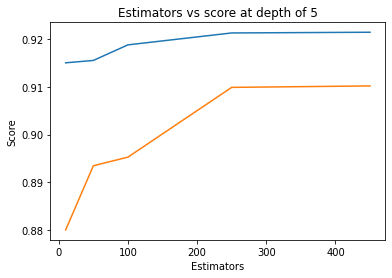

In [4]:
estimators = [10,50,100,250,450]

train_scores = []
test_scores = []

print(f'Number of estimator values : {len(estimators)}\n')

for i in estimators:
    
    clf = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini',
            max_depth = 5, max_features = 'auto', max_leaf_nodes = None,
            min_impurity_decrease = 0.0, min_samples_leaf = 52, min_samples_split = 120,
            min_weight_fraction_leaf = 0.0, n_estimators = i, n_jobs = -1, random_state = 25,
            verbose = 0, warm_start = False)
    
    clf.fit(df_final_train, y_train)
    
    train_sc = f1_score(y_train, clf.predict(df_final_train))
    test_sc = f1_score(y_test, clf.predict(df_final_test))
    
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    
    print(f'Estimators = {i} Train Score {train_sc} test Score {test_sc}')
    
# Ploting graph

plt.plot(estimators, train_scores, label = 'Train Score')
plt.plot(estimators, test_scores, label = 'Test Score')

plt.title('Estimators vs score at depth of 5')
plt.xlabel('Estimators')
plt.ylabel('Score')

plt.show()

Number of depth values : 5

depth = 3 Train Score 0.8882301114278309 test Score 0.8595610751956447
depth = 9 Train Score 0.9589804374474465 test Score 0.9226584079685277
depth = 11 Train Score 0.9622422276782557 test Score 0.9222784916084208
depth = 15 Train Score 0.9654490014337351 test Score 0.9203361344537815
depth = 20 Train Score 0.9658102407814803 test Score 0.923147799137245
depth = 35 Train Score 0.9659824106142149 test Score 0.9229931288754818
depth = 50 Train Score 0.9659824106142149 test Score 0.9229931288754818
depth = 70 Train Score 0.9659824106142149 test Score 0.9229931288754818
depth = 130 Train Score 0.9659824106142149 test Score 0.9229931288754818


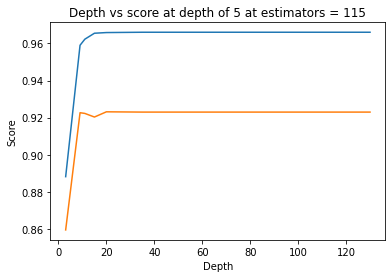

In [5]:
depths = [3,9,11,15,20,35,50,70,130]

train_scores = []
test_scores = []

print(f'Number of depth values : {len(estimators)}\n')

for i in depths:
    
    clf = RandomForestClassifier(bootstrap = True, class_weight = None, criterion = 'gini', max_depth = i,
          max_features = 'auto', max_leaf_nodes = None, min_impurity_decrease = 0.0, min_samples_leaf = 52,
          min_samples_split = 120, min_weight_fraction_leaf = 0.0, n_estimators = 115, n_jobs = -1,
          random_state = 25, verbose = 0, warm_start = False)
    
    clf.fit(df_final_train, y_train)
    
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    
    print(f'depth = {i} Train Score {train_sc} test Score {test_sc}')

# Ploting graph

plt.plot(depths, train_scores, label = 'Train Score')
plt.plot(depths, test_scores, label = 'Test Score')

plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.xlabel('Depth')
plt.ylabel('Score')

plt.show()

In [6]:
param_dist = {'n_estimators' : sp_randint(105,125),
              'max_depth' :  sp_randint(10,15),
              'min_samples_split' :  sp_randint(110,190),
              'min_samples_leaf' :  sp_randint(25,65) }

clf = RandomForestClassifier(random_state = 25, n_jobs = -1)

rf_random = RandomizedSearchCV(clf, param_distributions = param_dist, n_iter = 5, cv = 10,
                               scoring = 'f1', random_state = 25, return_train_score = True)

rf_random.fit(df_final_train,y_train)

print(f"Mean test scores   : {rf_random.cv_results_['mean_test_score']}\n")
print(f"Mean train scores  : {rf_random.cv_results_['mean_train_score']}\n")
print(f'Best Estimatores   : {rf_random.best_estimator_}')

Mean test scores   : [0.9637967  0.96349407 0.96174734 0.96321554 0.96495532]

Mean train scores  : [0.96499723 0.96451474 0.96254197 0.96423798 0.96659569]

Best Estimatores   : RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [7]:
# Taking Best Parameters

rf_n_estimators = rf_random.best_params_['n_estimators']
rf_max_depth = rf_random.best_params_['max_depth']
rf_min_samples_split = rf_random.best_params_['min_samples_split']
rf_min_samples_leaf = rf_random.best_params_['min_samples_leaf']

In [8]:
# Tunned Model

clf = RandomForestClassifier(n_estimators = rf_n_estimators, max_depth = rf_max_depth, 
                min_samples_leaf = rf_min_samples_leaf, min_samples_split = rf_min_samples_split,
                bootstrap = True, class_weight = None, criterion = 'gini', max_features = 'auto',
                max_leaf_nodes = None, min_impurity_decrease = 0.0, min_weight_fraction_leaf = 0.0,
                n_jobs = -1, oob_score = False, random_state = 25, verbose = 0, warm_start = False)

clf.fit(df_final_train,y_train)

y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [9]:
rf_f1_tr = f1_score(y_train ,y_train_pred)
rf_f1_te = f1_score(y_test, y_test_pred)

print(f'Train F1 score : {rf_f1_tr}\n')
print(f'Test F1 score  : {rf_f1_te}')

Train F1 score : 0.9661516712107442

Test F1 score  : 0.920854851576605


In [10]:
def plot_confusion_matrix(test_y, predict_y):
    
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T) / (C.sum(axis = 1))).T)
    
    B = (C / C.sum(axis = 0))
    
    plt.figure(figsize = (20, 4))
    
    labels = [0,1]
    
    # representing A in heatmap format
    cmap = sns.light_palette('aquamarine')
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot = True, cmap = cmap, fmt = '.3f', xticklabels = labels, yticklabels = labels)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot = True, cmap = cmap, fmt = '.3f', xticklabels = labels, yticklabels = labels)
    plt.title('Precision matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot = True, cmap = cmap, fmt = '.3f', xticklabels = labels, yticklabels = labels)
    plt.title('Recall matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')

    plt.show()

Train confusion_matrix


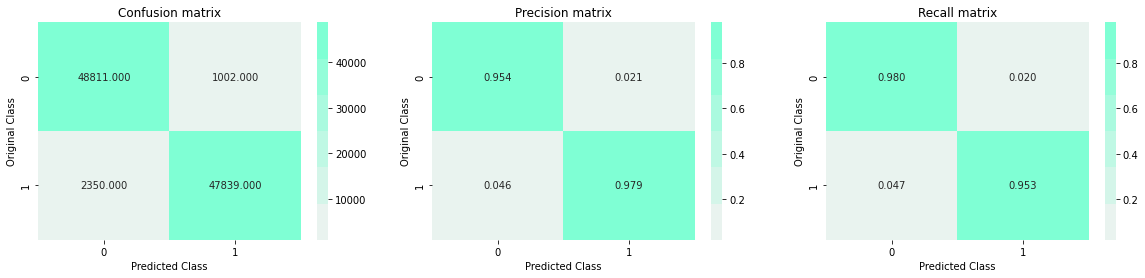


Test confusion_matrix


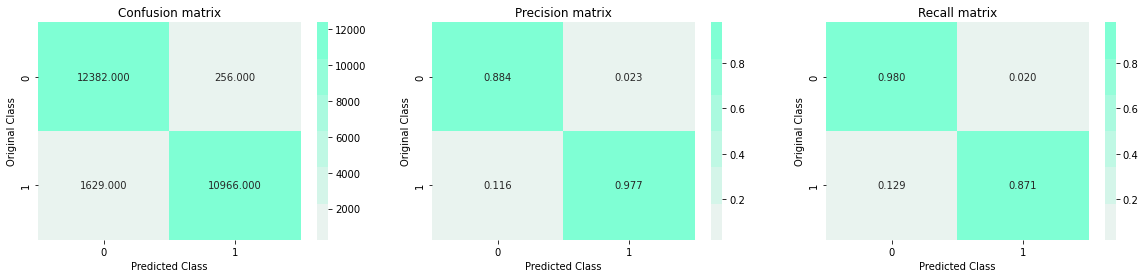

In [11]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train, y_train_pred)

print('\nTest confusion_matrix')
plot_confusion_matrix(y_test, y_test_pred)

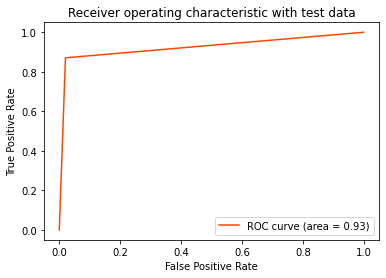

In [12]:
fpr, tpr, ths = roc_curve(y_test, y_test_pred)
rf_auc_sc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = 'orangered', label = 'ROC curve (area = %0.2f)' % rf_auc_sc)

plt.title('Receiver operating characteristic with test data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 4)

plt.show()

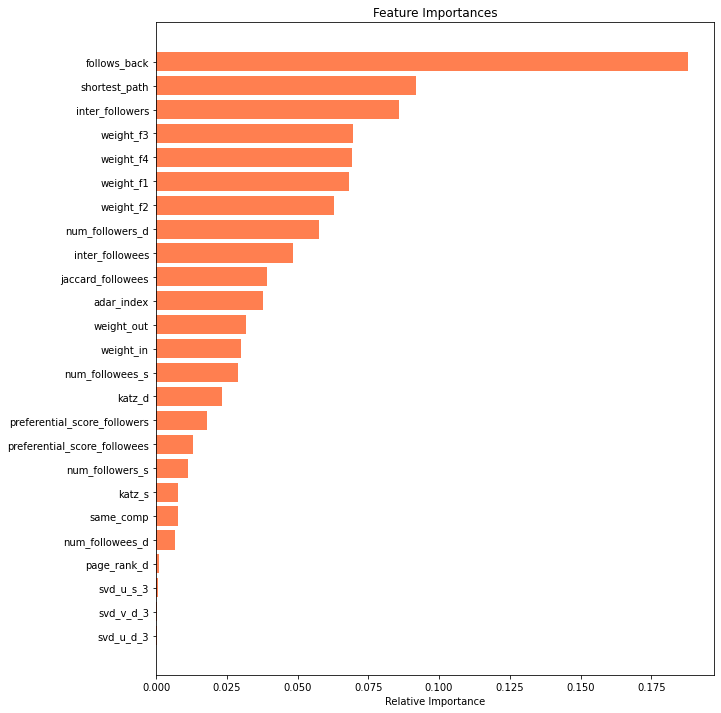

In [13]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]

plt.figure(figsize = (10, 12))
plt.barh(range(len(indices)), importances[indices], color = 'coral', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.title('Feature Importances')
plt.xlabel('Relative Importance')

plt.show()

## 2. <font color = 'red'>XG Boost</font>
With hyper-parameter tuning

In [14]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
n_estimators = [5, 10, 50, 75, 100, 200]
max_depth = [2, 3, 5, 6, 8, 9]


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier

xgb_model = xgb.XGBClassifier(verbosity = 0, n_jobs = -1)

parameters = {'n_estimators' : [5, 10, 50, 75, 100, 200], 'max_depth' : [2, 3, 5, 6, 8, 9]}

clf = RandomizedSearchCV(xgb_model , parameters, cv = 10, scoring = 'f1',
                         return_train_score = True, random_state = 25, n_jobs = -1)

r_search = clf.fit(df_final_train, y_train)

best_params_xgb = r_search.best_params_

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from p

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [n

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype

/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/jishnu/anaconda3/envs/AAIC_/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning:

In [15]:
print(f'\n{clf.best_estimator_}')
print(f'\n\nBest parameters : XGBClassifier : \n{best_params_xgb}')


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)


Best parameters : XGBClassifier : 
{'n_estimators': 200, 'max_depth': 5}


In [16]:
xgb_n_estimators = best_params_xgb['n_estimators']
xgb_max_depth = best_params_xgb['max_depth']

data = {'param_n_estimators' : r_search.cv_results_['param_n_estimators'],
'param_max_depth' : r_search.cv_results_['param_max_depth'],
'mean_train_score' : r_search.cv_results_['mean_train_score'],
'mean_test_score' : r_search.cv_results_['mean_test_score']}

xgb_performance = pd.DataFrame(data)
xgb_performance.sort_values(['mean_train_score', 'mean_test_score'], ascending = False)

,param_n_estimators,param_max_depth,mean_train_score,mean_test_score
1,100,8,0.999781,0.982436
4,200,5,0.998405,0.983713
9,75,8,0.998062,0.981581
5,100,6,0.994917,0.982187
7,200,3,0.986632,0.981385
6,50,5,0.981329,0.977932
3,100,3,0.980061,0.978175
0,5,9,0.976443,0.973369
8,10,6,0.969832,0.969287
2,5,3,0.932371,0.932217


In [17]:
xgb_model = xgb.XGBClassifier(n_estimators = xgb_n_estimators, max_depth = xgb_max_depth ,
                              use_label_encoder = False, verbosity=0,  n_jobs = -1)

xgb_model.fit(df_final_train,y_train)

y_train_pred = xgb_model.predict(df_final_train)
y_test_pred = xgb_model.predict(df_final_test)

In [18]:
xgb_f1_tr = f1_score(y_train ,y_train_pred)
xgb_f1_te = f1_score(y_test, y_test_pred)

print(f'Train F1 score : {xgb_f1_tr}\n')
print(f'Test F1 score  : {xgb_f1_te}')

Train F1 score : 0.9983049495473219

Test F1 score  : 0.9087558393691338


Train confusion_matrix


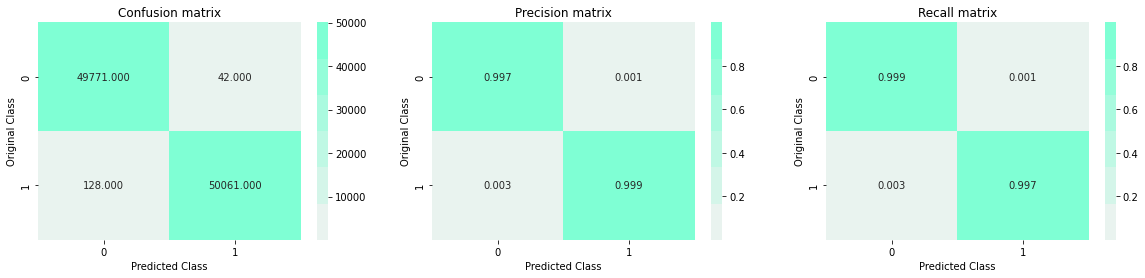


Test confusion_matrix


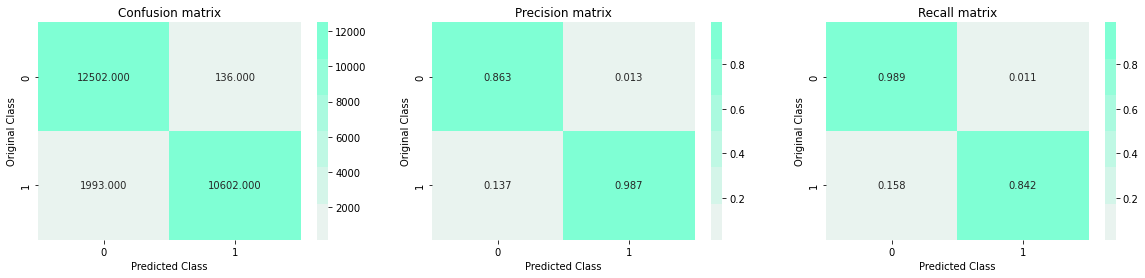

In [19]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train, y_train_pred)

print('\nTest confusion_matrix')
plot_confusion_matrix(y_test, y_test_pred)

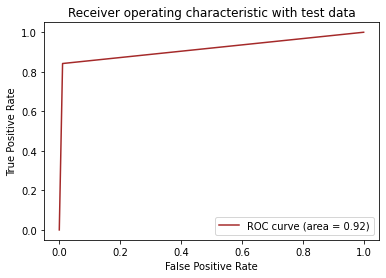

In [20]:
fpr, tpr, ths = roc_curve(y_test, y_test_pred)
xgb_auc_sc = auc(fpr, tpr)

plt.plot(fpr, tpr, color = 'brown', label = 'ROC curve (area = %0.2f)' % xgb_auc_sc)

plt.title('Receiver operating characteristic with test data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 4)

plt.show()

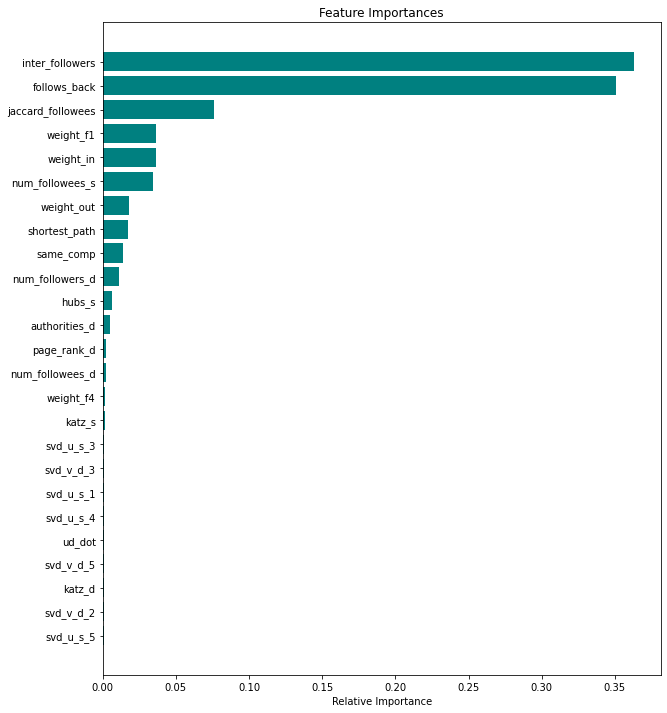

In [21]:
features = df_final_train.columns
importances = xgb_model.feature_importances_
indices = (np.argsort(importances))[-25:]

plt.figure(figsize = (10, 12))
plt.barh(range(len(indices)), importances[indices], color = 'teal', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.title('Feature Importances')
plt.xlabel('Relative Importance')

plt.show()

# <font color = 'blue'>Conclusion</font>

In [23]:
p = PrettyTable()

p.field_names = ['Model', 'n_estimators', 'max_depth', 'Train F1 Score', 'Test F1 Score', 'AUC Score']
p.add_row(['Random Forest', rf_n_estimators, rf_max_depth, round(rf_f1_tr, 3),
                                                       round(rf_f1_te, 3), round(rf_auc_sc, 3)])

p.add_row(['XG Boost', xgb_n_estimators, xgb_max_depth, round(xgb_f1_tr, 3),
                                                       round(xgb_f1_te, 3), round(xgb_auc_sc, 3)])

time_modeling = time.time()

print(f'Total time took for modeling    : {round((time_modeling - time_start) / 60, 1)} minutes\n')  

print(p)

Total time took for modeling    : 56.0 minutes

+---------------+--------------+-----------+----------------+---------------+-----------+
|     Model     | n_estimators | max_depth | Train F1 Score | Test F1 Score | AUC Score |
+---------------+--------------+-----------+----------------+---------------+-----------+
| Random Forest |     121      |     14    |     0.966      |     0.921     |   0.925   |
|    XG Boost   |     200      |     5     |     0.998      |     0.909     |   0.916   |
+---------------+--------------+-----------+----------------+---------------+-----------+


### Procedure & Observations

- Load the data which is having only source node and destination node.
- Using visualising library and python module `networkx` plotted graph connection using **60** sample data points.
- On exploratory data analysis,  we found that only a very few have large count on number of followers and following.
- To pose this problem as a classification one, generated edges from the base data.
- The data splits into a ratio of 80 : 20 for train and test purposes.
- Using references like [Link Prediction Algorithms](http://be.amazd.com/link-prediction/) and [Graph-based Features for Supervised Link Prediction](https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf) and others, developed new features from original two columns **source node** and **destination node ** and visulized some to see the behaviour of new features.
- Newly generated features are added to train and test data and saved those files at every interval of time.
- On **modelling**  part, we took hyper-parameter tuning for optimising machine learning algorithms like **Random Forest Classifier** and **XG Boost**. 
- Using predicted values we calculated **F1 Score**, **Area under the curve (AUC)** as an error matric.
- Using the **feature importance** feature of algorithms we found out the most important feature among all our generated features.
---
- While in `RandomForestClassifier` we found `follow_back`, `shortest_path` amd `inter-followers` as top 3 most important features with a score of almost **0.18**, **0.1**, **0.09**.
- While with `XGBoost` we found `inter-followers`, `follow_back`and `jaccard_followees` came as top 3 most important features with a score of almost a great relative importance scores of **0.37**, **0.35**, **0.1**.
- With `XGBoost` shows that the most important features among all are `inter-followers` and `follow_back`. These 2 contributess more-than 70% of the feaature importance scale.